In [ ]:
import os, cv2, numpy as np, json
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from joblib import dump
from pathlib import Path
from skimage.feature import hog
import random
import matplotlib.pyplot as plt
from skimage import exposure
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import wandb

Sampling SIFT for codebook:  13%|█▎        | 306/2374 [00:10<01:12, 28.69it/s]


Collected descriptors for codebook: (200251, 128)


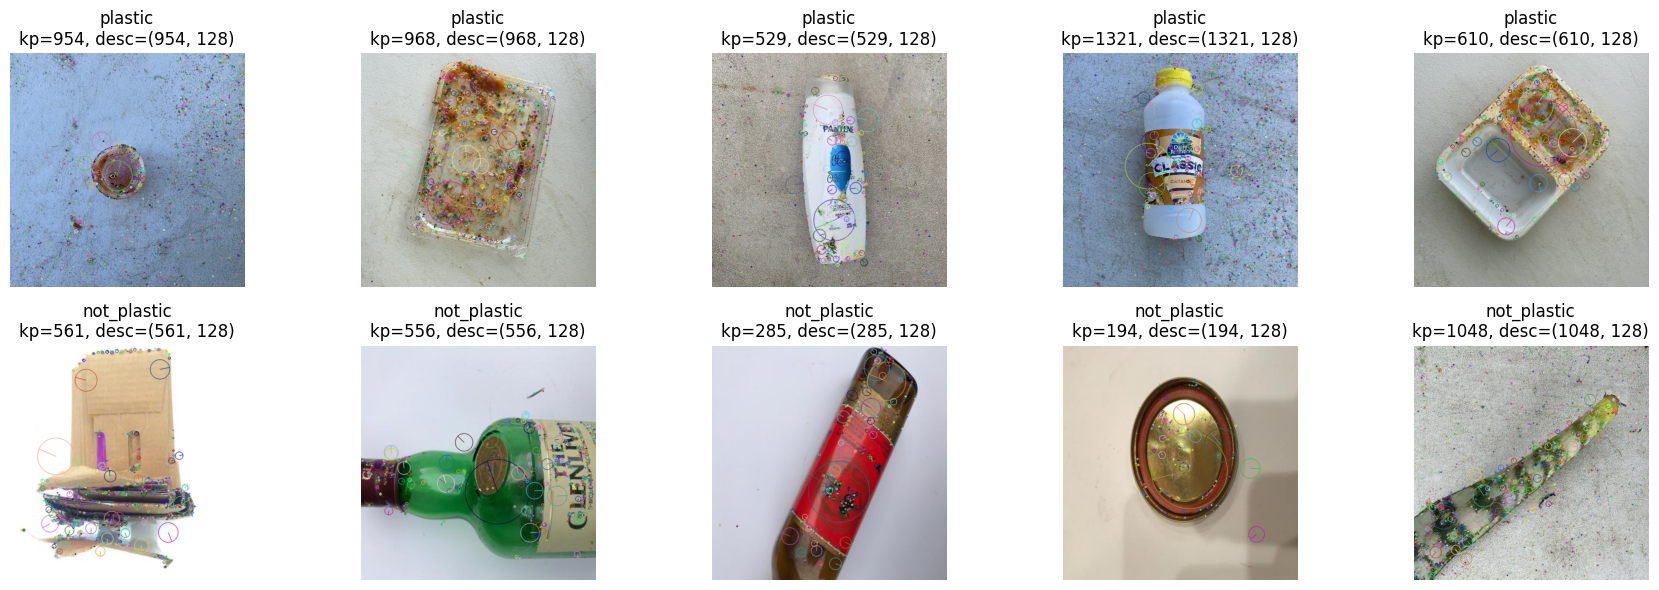

Saved codebook to: D:\SEM 7\CVProject\features_bovw_sift


train BoVW saved: (2374, 2048) labels: (2374,)


val BoVW saved: (510, 2048) labels: (510,)


test BoVW saved: (507, 2048) labels: (507,)


In [24]:
# --- SIFT → BoVW codebook + per-image histograms ---
BASE = r"D:\SEM 7\CVProject\pretraning_dataset"
SPLITS = ["train", "val", "test"]
CLASSES = ["plastic", "not_plastic"]

# BoVW config
K = 2048                          # vocabulary size
MAX_DESC_PER_IMG = 2000          # cap SIFT descriptors per image (for sampling)
MAX_DESCS_TOTAL = 200_000        # total descriptors to sample for k-means
BATCH_SIZE = 10_000              # MiniBatchKMeans batch size
RANDOM_STATE = 42

OUT_DIR = Path(BASE).parent / "features_bovw_sift"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def list_images(root):
    return [str(Path(root, f)) for f in os.listdir(root)
            if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tif','.tiff','.webp'))]

def sift_descriptors(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kps, desc = sift.detectAndCompute(gray, None)
    return desc  # shape (n_kp, 128) or None

# 1) Collect SIFT descriptors from TRAIN only for codebook
train_paths = []
for c in CLASSES:
    cdir = Path(BASE, "train", c)
    if cdir.is_dir():
        train_paths += list_images(cdir)

rng = np.random.default_rng(RANDOM_STATE)
all_desc = []
seen = 0
for p in tqdm(train_paths, desc="Sampling SIFT for codebook"):
    img = cv2.imread(p)
    if img is None: 
        continue
    d = sift_descriptors(img)
    if d is None or len(d) == 0:
        continue
    # cap per image
    if len(d) > MAX_DESC_PER_IMG:
        idx = rng.choice(len(d), size=MAX_DESC_PER_IMG, replace=False)
        d = d[idx]
    all_desc.append(d)
    seen += len(d)
    if sum(len(x) for x in all_desc) >= MAX_DESCS_TOTAL:
        break

if len(all_desc) == 0:
    raise RuntimeError("No SIFT descriptors found in training set. Check your images and paths.")

sampled = np.vstack(all_desc)
print("Collected descriptors for codebook:", sampled.shape)

# Pick 5 random images from plastic and not_plastic (train split)
sample_visuals = {}
for cls in CLASSES:
    cdir = Path(BASE, "train", cls)
    if cdir.is_dir():
        imgs = list_images(cdir)
        sample_visuals[cls] = random.sample(imgs, min(5, len(imgs)))

# Plot them with SIFT keypoints
sift = cv2.SIFT_create()

fig, axes = plt.subplots(len(CLASSES), 5, figsize=(18, 6))
for row, cls in enumerate(CLASSES):
    for col, p in enumerate(sample_visuals[cls]):
        img = cv2.imread(p)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kps, desc = sift.detectAndCompute(gray, None)
        
        # Draw keypoints on a copy
        img_kp = cv2.drawKeypoints(img, kps, None,
                                   flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        img_rgb = cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB)
        
        axes[row, col].imshow(img_rgb)
        axes[row, col].set_title(f"{cls}\nkp={len(kps)}, desc={None if desc is None else desc.shape}")
        axes[row, col].axis("off")

plt.tight_layout()
plt.show()

# 2) Fit MiniBatchKMeans vocabulary
kmeans = MiniBatchKMeans(n_clusters=K, batch_size=BATCH_SIZE, random_state=RANDOM_STATE, verbose=0)
kmeans.fit(sampled)
dump(kmeans, OUT_DIR / f"kmeans_k{K}.joblib")
with open(OUT_DIR / "bovw_config.json", "w") as f:
    json.dump({"K": K, "MAX_DESC_PER_IMG": MAX_DESC_PER_IMG}, f, indent=2)
print("Saved codebook to:", OUT_DIR)

# 3) Build BoVW histograms for ALL images (train/val/test) and save
for split in SPLITS:
    X = []
    y = []
    paths = []
    for cls_idx, c in enumerate(CLASSES):
        cdir = Path(BASE, split, c)
        if not cdir.is_dir():
            continue
        imgs = list_images(cdir)
        for p in tqdm(imgs, desc=f"BoVW {split}/{c}", leave=False):
            img = cv2.imread(p)
            if img is None:
                continue
            d = sift_descriptors(img)
            if d is None or len(d) == 0:
                # empty histogram if no descriptors
                hist = np.zeros(K, dtype=np.float32)
            else:
                # assign to nearest clusters
                idx = kmeans.predict(d)
                hist = np.bincount(idx, minlength=K).astype(np.float32)
                # L1 normalize
                s = hist.sum()
                if s > 0:
                    hist /= s
            X.append(hist)
            y.append(cls_idx)
            paths.append(p)
    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int32)
    np.save(OUT_DIR / f"X_bovw_{split}.npy", X)
    np.save(OUT_DIR / f"y_{split}.npy", y)
    with open(OUT_DIR / f"paths_{split}.json", "w") as f:
        json.dump(paths, f, indent=2)
    print(split, "BoVW saved:", X.shape, "labels:", y.shape)


train HOG saved: (2374, 34596) labels: (2374,)


val HOG saved: (510, 34596) labels: (510,)


test HOG saved: (507, 34596) labels: (507,)


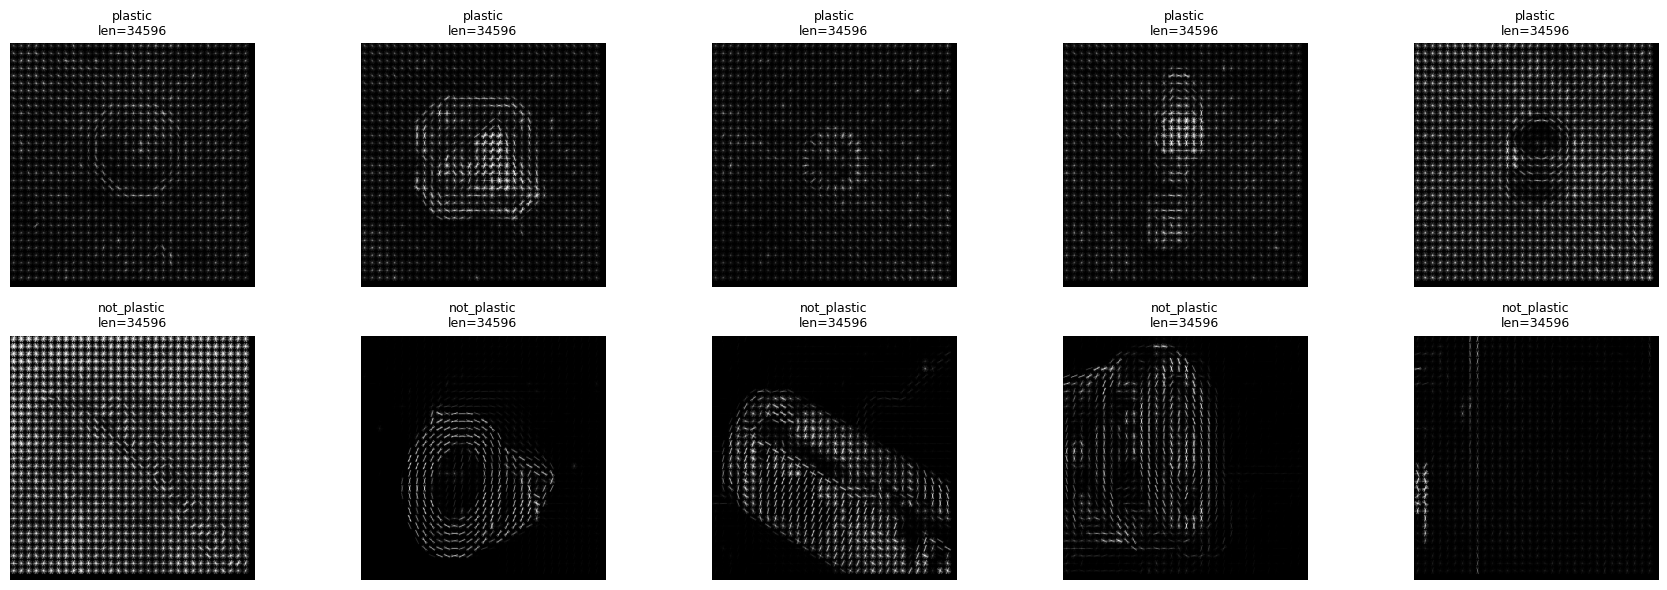

In [25]:
# --- HOG extraction ---
# Paths & splits
BASE = r"D:\SEM 7\CVProject\pretraning_dataset"
SPLITS = ["train", "val", "test"]
CLASSES = ["plastic", "not_plastic"]

# HOG config 
HOG_PARAMS = dict(
    orientations=9,
    pixels_per_cell=(16,16),
    cells_per_block=(2,2),
    block_norm="L2-Hys",
    feature_vector=True
)

OUT_DIR = Path(BASE).parent / "features_hog"
OUT_DIR.mkdir(parents=True, exist_ok=True)
with open(OUT_DIR / "hog_config.json", "w") as f:
    json.dump({k: (v if not isinstance(v, tuple) else list(v)) for k,v in HOG_PARAMS.items()}, f, indent=2)

def list_images(root):
    return [str(Path(root, f)) for f in os.listdir(root)
            if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tif','.tiff','.webp'))]

# --------- Feature extraction ----------
for split in SPLITS:
    X, y, paths = [], [], []
    for cls_idx, c in enumerate(CLASSES):
        cdir = Path(BASE, split, c)
        if not cdir.is_dir():
            continue
        imgs = list_images(cdir)
        for p in tqdm(imgs, desc=f"HOG {split}/{c}", unit="img", leave=False):
            img = cv2.imread(p)
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            feat = hog(gray, **HOG_PARAMS)  
            X.append(feat.astype(np.float32))
            y.append(cls_idx)
            paths.append(p)

    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int32)
    np.save(OUT_DIR / f"X_hog_{split}.npy", X)
    np.save(OUT_DIR / f"y_{split}.npy", y)
    with open(OUT_DIR / f"paths_{split}.json", "w") as f:
        json.dump(paths, f, indent=2)
    print(split, "HOG saved:", X.shape, "labels:", y.shape)

# --------- Visual check ----------
sample_visuals = {}
for cls in CLASSES:
    cdir = Path(BASE, "train", cls)
    if cdir.is_dir():
        imgs = list_images(cdir)
        if len(imgs) > 0:
            sample_visuals[cls] = random.sample(imgs, min(5, len(imgs)))
        else:
            sample_visuals[cls] = []

rows = len(CLASSES)
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(18, 6))

for row, cls in enumerate(CLASSES):
    # handle case with fewer than 5 images gracefully
    picks = sample_visuals.get(cls, [])
    for col in range(cols):
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis("off")
        if col >= len(picks):
            continue
        p = picks[col]
        img = cv2.imread(p)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        feat, hog_image = hog(gray, **HOG_PARAMS, visualize=True)
        # Rescale for better contrast
        hog_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        ax.imshow(hog_rescaled, cmap="gray")
        ax.set_title(f"{cls}\nlen={len(feat)}", fontsize=9)

plt.tight_layout()
plt.show()

In [27]:
# --- HSV color histogram per image (H=12, S=4, V=3) ---
BASE = r"D:\SEM 7\CVProject\pretraning_dataset"
SPLITS = ["train", "val", "test"]
CLASSES = ["plastic", "not_plastic"]

H_BINS, S_BINS, V_BINS = 12, 4, 3
OUT_DIM = H_BINS * S_BINS + V_BINS  # 48 + 3 = 51

OUT_DIR = Path(BASE).parent / "features_hsv"
OUT_DIR.mkdir(parents=True, exist_ok=True)
with open(OUT_DIR / "hsv_config.json", "w") as f:
    json.dump({"H_BINS": H_BINS, "S_BINS": S_BINS, "V_BINS": V_BINS}, f, indent=2)

def list_images(root):
    return [str(Path(root, f)) for f in os.listdir(root)
            if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tif','.tiff','.webp'))]

def hsv_feature(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    # HS 2D hist
    hs_hist = cv2.calcHist([H, S], [0,1], None, [H_BINS, S_BINS], [0,180, 0,256])
    hs_hist = hs_hist.flatten().astype(np.float32)
    # V 1D hist
    v_hist = cv2.calcHist([V], [0], None, [V_BINS], [0,256]).flatten().astype(np.float32)
    # L1 normalize each, then concat
    if hs_hist.sum() > 0: hs_hist /= hs_hist.sum()
    if v_hist.sum()  > 0: v_hist  /= v_hist.sum()
    return np.concatenate([hs_hist, v_hist], axis=0)  # 51-dim

for split in SPLITS:
    X = []
    y = []
    paths = []
    for cls_idx, c in enumerate(CLASSES):
        cdir = Path(BASE, split, c)
        if not cdir.is_dir():
            continue
        imgs = list_images(cdir)
        for p in tqdm(imgs, desc=f"HSV {split}/{c}", leave=False):
            img = cv2.imread(p)
            if img is None:
                continue
            feat = hsv_feature(img)
            X.append(feat)
            y.append(cls_idx)
            paths.append(p)
    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int32)
    np.save(OUT_DIR / f"X_hsv_{split}.npy", X)
    np.save(OUT_DIR / f"y_{split}.npy", y)
    with open(OUT_DIR / f"paths_{split}.json", "w") as f:
        json.dump(paths, f, indent=2)
    print(split, "HSV saved:", X.shape, "labels:", y.shape)


train HSV saved: (2374, 51) labels: (2374,)


val HSV saved: (510, 51) labels: (510,)


test HSV saved: (507, 51) labels: (507,)


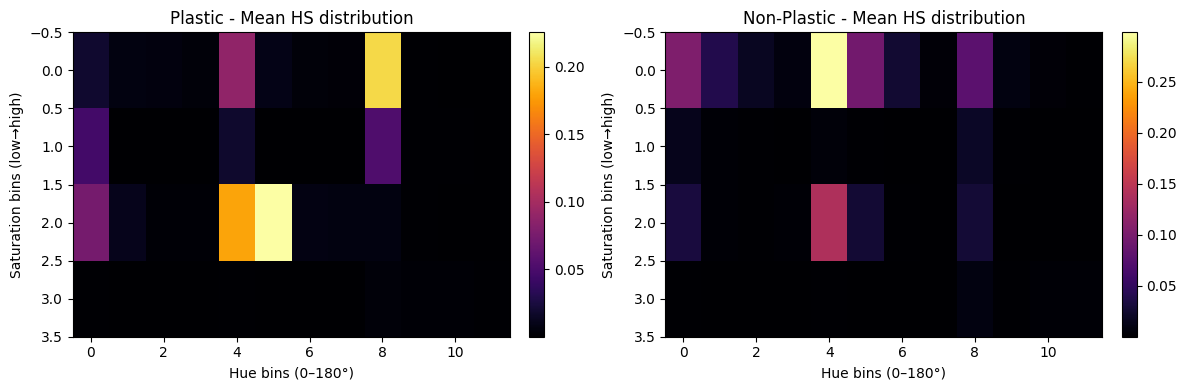

In [28]:
# --- HSV heatmap visualization (plastic vs non-plastic) ---
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

BASE = r"D:\SEM 7\CVProject\pretraning_dataset"
FEAT_DIR = str(Path(BASE).parent / "features_hsv")

# Load train features
X = np.load(os.path.join(FEAT_DIR, "X_hsv_train.npy"))  # (N, 51)
y = np.load(os.path.join(FEAT_DIR, "y_train.npy"))      # (N,)

# Split into classes
plastic_feats = X[y == 0]
nonplastic_feats = X[y == 1]

# HS = first 48 bins, V = last 3 bins
plastic_hs = plastic_feats[:, :48]
nonplastic_hs = nonplastic_feats[:, :48]

# Compute mean HS histograms
plastic_hs_mean = plastic_hs.mean(axis=0).reshape(4, 12)      # (S_bins, H_bins)
nonplastic_hs_mean = nonplastic_hs.mean(axis=0).reshape(4, 12)

# --- Plot heatmaps ---
fig, axes = plt.subplots(1, 2, figsize=(12,4))

im1 = axes[0].imshow(plastic_hs_mean, cmap="inferno", aspect="auto")
axes[0].set_title("Plastic - Mean HS distribution")
axes[0].set_xlabel("Hue bins (0–180°)")
axes[0].set_ylabel("Saturation bins (low→high)")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(nonplastic_hs_mean, cmap="inferno", aspect="auto")
axes[1].set_title("Non-Plastic - Mean HS distribution")
axes[1].set_xlabel("Hue bins (0–180°)")
axes[1].set_ylabel("Saturation bins (low→high)")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [29]:
# --- CONCATENATE BoVW (512) + HOG (~34596) + HSV (51), then scale ---
BASE = r"D:\SEM 7\CVProject\pretraning_dataset"

DIR_BOVW = str(Path(BASE).parent / "features_bovw_sift")
DIR_HOG  = str(Path(BASE).parent / "features_hog")
DIR_HSV  = str(Path(BASE).parent / "features_hsv")

def load_split(split):
    X_bovw = np.load(os.path.join(DIR_BOVW, f"X_bovw_{split}.npy"))   # (N,512)
    X_hog  = np.load(os.path.join(DIR_HOG,  f"X_hog_{split}.npy"))    # (N,~34596)
    X_hsv  = np.load(os.path.join(DIR_HSV,  f"X_hsv_{split}.npy"))    # (N,51)
    y_b    = np.load(os.path.join(DIR_BOVW, f"y_{split}.npy"))        # (N,)
    y_h    = np.load(os.path.join(DIR_HOG,  f"y_{split}.npy"))
    y_s    = np.load(os.path.join(DIR_HSV,  f"y_{split}.npy"))

    # sanity: labels must match order/length
    assert (y_b == y_h).all() and (y_b == y_s).all(), f"Label mismatch in {split}"
    # concatenate in agreed order
    X = np.hstack([X_bovw, X_hog, X_hsv]).astype(np.float32)
    y = y_b.astype(np.int32)
    return X, y

# Load all splits
X_train, y_train = load_split("train")
X_val,   y_val   = load_split("val")
X_test,  y_test  = load_split("test")

print("Shapes:")
print("  train:", X_train.shape, y_train.shape)
print("  val  :", X_val.shape,   y_val.shape)
print("  test :", X_test.shape,  y_test.shape)

# Scale (z-score) so blocks have comparable ranges
scaler = StandardScaler(with_mean=False)  # sparse-friendly behavior; features are non-negative hist-like
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("Scaled shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)

# Optional: save scaler for later inference
from joblib import dump
ART_DIR = Path(BASE).parent / "artifacts_rf"
ART_DIR.mkdir(parents=True, exist_ok=True)
dump(scaler, ART_DIR / "scaler_rf.joblib")


Shapes:
  train: (2374, 36695) (2374,)
  val  : (510, 36695) (510,)
  test : (507, 36695) (507,)
Scaled shapes: (2374, 36695) (510, 36695) (507, 36695)


['D:\\SEM 7\\CVProject\\artifacts_rf\\scaler_rf.joblib']

In [30]:
# --- Train Random Forest + validation eval (plastic-positive, with threshold sweep) ---
use_wandb = True
run = None
if use_wandb:
    try:
        import wandb
        wandb.login()
        run = wandb.init(
            project="cv-plastic-pretraining",
            config={
                "model": "RandomForest",
                "n_estimators": 800,                 # a bit more trees for stability
                "max_depth": None,
                "class_weight": "balanced",          # <— change 1: stronger balancing
                "features": ["BoVW512","HOG~34600","HSV51"],
                "scaler": "StandardScaler(with_mean=False)",
            },
            name="rf_bovw-hog-hsv",
            reinit=True
        )
    except Exception as e:
        print("wandb disabled:", e)
        use_wandb = False

# Train RF
rf = RandomForestClassifier(
    n_estimators=800,
    max_depth=None,
    class_weight="balanced",      # <— change 1 mirrored here
    n_jobs=-1,
    oob_score=True,
    random_state=42
)

print("Fitting RandomForest...")
rf.fit(X_train_s, y_train)

# OOB check
if hasattr(rf, "oob_score_"):
    print(f"OOB score: {rf.oob_score_:.4f}")
    if use_wandb and run:
        wandb.log({"oob_score": rf.oob_score_})

# ===== VALIDATION with PLASTIC probability & THRESHOLD SWEEP =====
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np

classes_list = rf.classes_.tolist()
try:
    plastic_idx = classes_list.index(0)  # 0 = plastic in your labels
except ValueError:
    raise RuntimeError(f"Expected label '0' (plastic) in rf.classes_, found: {classes_list}")

val_proba_plastic = rf.predict_proba(X_val_s)[:, plastic_idx]

def sweep_thresholds(y_true, probs, n=61):
    ths = np.linspace(0.05, 0.95, n)
    best = None
    rows = []
    for t in ths:
        preds = np.where(probs >= t, 0, 1)  # 0=plastic, 1=not_plastic
        p, r, f1, _ = precision_recall_fscore_support(y_true, preds, average="binary",
                                                      pos_label=0, zero_division=0)
        rows.append((t, p, r, f1))
        score = (p, f1)  # prioritize plastic precision, tie-break by F1
        if best is None or score > (best[1], best[3]):
            best = (t, p, r, f1)
    return np.array(rows), best

rows, best = sweep_thresholds(y_val, val_proba_plastic, n=91)
best_t, best_p, best_r, best_f1 = best
print(f"\nChosen τ on val (plastic prob): {best_t:.2f}  -> P_plastic={best_p:.3f}, R_plastic={best_r:.3f}, F1_plastic={best_f1:.3f}")

# Metrics at chosen τ (VAL)
val_pred_labels = np.where(val_proba_plastic >= best_t, 0, 1)
print("\nValidation @ chosen τ (plastic positive):")
print(classification_report(y_val, val_pred_labels, target_names=["plastic","not_plastic"]))
print("Confusion matrix (val):\n", confusion_matrix(y_val, val_pred_labels))

if use_wandb and run:
    acc = (val_pred_labels == y_val).mean()
    wandb.log({"val_tau": float(best_t),
               "val_acc": acc,
               "val_precision_plastic": best_p,
               "val_recall_plastic": best_r,
               "val_f1_plastic": best_f1})

# Save model
from joblib import dump
dump(rf, ART_DIR / "rf_model.joblib")
print("Saved RF to:", ART_DIR / "rf_model.joblib")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


oob_score,▁
val_acc,▁
val_f1_plastic,▁
val_precision_plastic,▁
val_recall_plastic,▁
oob_score,0.89553
val_acc,0.43922
val_f1_plastic,0.60606
val_precision_plastic,0.43651
val_recall_plastic,0.99099


Fitting RandomForest...
OOB score: 0.8993

Chosen τ on val (plastic prob): 0.05  -> P_plastic=0.313, R_plastic=0.468, F1_plastic=0.375

Validation @ chosen τ (plastic positive):
              precision    recall  f1-score   support

     plastic       0.31      0.47      0.38       222
 not_plastic       0.34      0.21      0.26       288

    accuracy                           0.32       510
   macro avg       0.33      0.34      0.32       510
weighted avg       0.33      0.32      0.31       510

Confusion matrix (val):
 [[104 118]
 [228  60]]
Saved RF to: D:\SEM 7\CVProject\artifacts_rf\rf_model.joblib


In [23]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np

# plastic is label 0 in your y's
plastic_idx = rf.classes_.tolist().index(0)
val_proba_plastic = rf.predict_proba(X_val_s)[:, plastic_idx]

def choose_tau(y_true, probs, target_precision=0.75, n=201):
    ths = np.linspace(0.0, 1.0, n)
    best_f1 = (-1, 0.0)  # (f1, tau)
    best_prec_target = None  # (recall, tau, precision, f1)
    for t in ths:
        preds = np.where(probs >= t, 0, 1)  # 0=plastic, 1=not_plastic
        p, r, f1, _ = precision_recall_fscore_support(y_true, preds, average="binary", pos_label=0, zero_division=0)
        if f1 > best_f1[0]:
            best_f1 = (f1, t)
        if p >= target_precision:
            if best_prec_target is None or r > best_prec_target[0]:
                best_prec_target = (r, t, p, f1)
    return {"best_f1": best_f1, "best_prec_target": best_prec_target}

choice = choose_tau(y_val, val_proba_plastic, target_precision=0.75, n=201)
(best_f1, tau_f1) = choice["best_f1"]
if choice["best_prec_target"] is not None:
    r_best, tau_prec, p_best, f1_at_prec = choice["best_prec_target"]
    print(f"Chosen τ for precision≥0.75: τ={tau_prec:.3f}  P={p_best:.3f}  R={r_best:.3f}  F1={f1_at_prec:.3f}")
    chosen_tau = tau_prec
else:
    print(f"No τ reached precision≥0.75. Using F1-optimal τ={tau_f1:.3f}  F1={best_f1:.3f}")
    chosen_tau = tau_f1

# Evaluate at chosen τ
val_pred = np.where(val_proba_plastic >= chosen_tau, 0, 1)
print("\nValidation @ chosen τ:")
print(classification_report(y_val, val_pred, target_names=["plastic","not_plastic"]))
print("Confusion matrix (val):\n", confusion_matrix(y_val, val_pred))


No τ reached precision≥0.75. Using F1-optimal τ=0.015  F1=0.607

Validation @ chosen τ:
              precision    recall  f1-score   support

     plastic       0.44      0.99      0.61       222
 not_plastic       0.73      0.03      0.05       288

    accuracy                           0.45       510
   macro avg       0.58      0.51      0.33       510
weighted avg       0.60      0.45      0.29       510

Confusion matrix (val):
 [[219   3]
 [280   8]]
